In [1]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

What other types of models (i.e. different classifcation algorithms) could you use?


How do the models compare when trained on term frequency data alone, instead of TF-IDF values?

In [3]:
document = 'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
a,3,0.272727,1.000000
little,3,0.272727,1.000000
lamb,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


Text(0.5, 1.0, 'IDF for a given word')

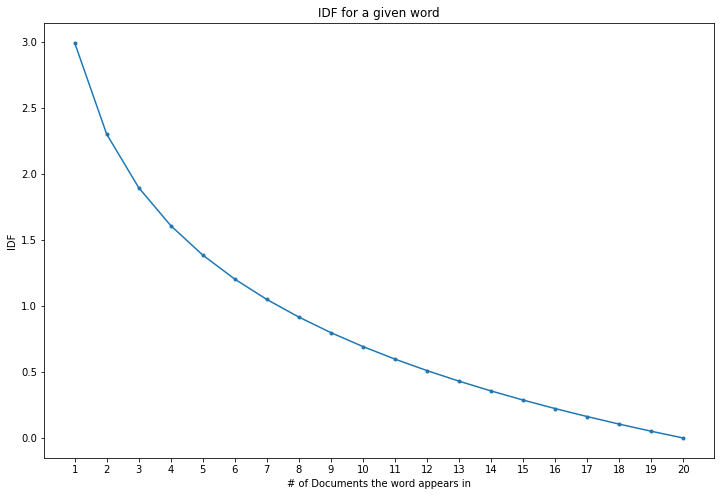

In [4]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

In [5]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': 'codeups data science program wa created in response to a '
            'percieved lack of data science talent and growing demand',
 'description': 'codeups data science program teach hand on skill using python '
                'and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


In [6]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


In [7]:
tfs = []

# We'll caclulate the tf-idf value for every word across every document

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False))

,word,doc,tf_idf
5,hand,description,0.250000
4,teach,description,0.250000
11,panda,description,0.250000
9,python,description,0.250000
8,using,description,0.250000
7,skill,description,0.250000
14,wa,context,0.176471
13,created,context,0.176471
11,response,context,0.176471
9,to,context,0.176471


In [8]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

word,18,a,and,announced,codeup,codeups,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x37 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [11]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.51%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   109
spam          2   489
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



In [12]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.14%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        963    40
spam         3   109
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.97      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

